In [1]:
import numpy as np
from numpy.typing import ArrayLike
import matplotlib.pyplot as plt

## define PSF

In [ ]:
def R_lambda(q_obs, q_mod, lambda_ratio_list, w_lambda, mu_q):
    r"""
    Constructs the full polychromatic point-spread function R(q, q') such that

        I_obs(q) = ∫ R(q, q') I_mod(q') dq'  ≈  (R @ I_mod)(q)

    Parameters
    ----------
    q_obs : (M_obs,) ndarray
        Q-values where the observed intensity I_obs(q) is evaluated.
    q_mod : (M_mod,) ndarray
        Q'-values defining the latent/model intensity I_mod(q').
    lambda_ratio_list : (N,) ndarray
        Ratios ρ_i = λ_i / λ_0 for each wavelength component.
    w_lambda : (N,) ndarray
        Normalized spectral weights (∑ w_lambda = 1).
    mu_q : float
        Gaussian width (in Q-units) controlling the mapping spread from q_mod → q_obs.

        - Small mu_q  → narrow PSF, nearly δ(q−ρq′)
        - Large mu_q  → broad smearing, stronger convolution

    Returns
    -------
    R : (M_obs, M_mod) ndarray
        Discrete kernel approximating R(q, q') including wavelength distribution.

    Notes
    -----
    Implements:
        R(q,q') = Σ_i w_i · [ exp(−(q − ρ_i q')² / (2 μ_q²)) / Z_i(q') ]
    where Z_i(q') ensures ∫ R(q,q') dq = 1 for each q'.

    --------------------------------------------------------------------------
    LaTeX source 
    --------------------------------------------------------------------------
    \begin{equation}
        R(q,q')
        \;=\;
        \sum_{i} w_i \,
        \frac{
            \exp\!\left[-\dfrac{(q - \rho_i q')^2}{2\,\mu_q^2}\right]
        }{
            Z_i(q')
        },
        \qquad
        Z_i(q')
        \;=\;
        \int_{-\infty}^{\infty}
        \exp\!\left[-\dfrac{(q - \rho_i q')^2}{2\,\mu_q^2}\right]
        \mathrm{d}q.
        \label{eq:R_q_def}
    \end{equation}
    --------------------------------------------------------------------------
    """
    q_obs = np.asarray(q_obs)
    q_mod = np.asarray(q_mod)
    lambda_ratio_list = np.asarray(lambda_ratio_list)
    w_lambda = np.asarray(w_lambda)

    M_obs, M_mod = q_obs.size, q_mod.size
    R = np.zeros((M_obs, M_mod), dtype=float)

    # --- Implements: R(q, q') = Σ_i w_i * exp[-(q - ρ_i q')² / (2 μ_q²)] / Z_i(q') ---
    for rho, w_i in zip(lambda_ratio_list, w_lambda):
        q_center = rho * q_mod[None, :]           # Shift q' → ρ_i q'
        diff = q_obs[:, None] - q_center          # (M_obs, M_mod)
        phi = np.exp(-0.5 * (diff / mu_q) ** 2)

        # Normalize over q_obs for each q' (column-wise)
        Z_i = phi.sum(axis=0, keepdims=True)
        Z_i[Z_i == 0] = 1.0
        phi /= Z_i

        # Weighted sum over wavelength components
        R += w_i * phi

    return R

In [90]:
# -----------------------------------------------------------------------------
# Utilities
# -----------------------------------------------------------------------------

def _ensure_1d(a: ArrayLike) -> np.ndarray:
    a = np.asarray(a, dtype=float)
    if a.ndim != 1:
        raise ValueError("Input arrays must be 1D")
    return a


def _gauss_legendre_ab(a: float, b: float, n: int) -> tuple[np.ndarray, np.ndarray]:
    """Return Gauss–Legendre nodes x and weights w mapped to [a, b]."""
    t, w = np.polynomial.legendre.leggauss(n)
    # map from [-1,1] to [a,b]
    x = 0.5 * (b - a) * t + 0.5 * (a + b)
    w = 0.5 * (b - a) * w
    return x, w


def _gaussian_smoother(Q_mod: np.ndarray, mu_Q: float) -> np.ndarray:
    """Row-normalized Gaussian kernel S over Q_mod with std=mu_Q.

    S has shape (M_mod, M_mod) and rows sum to 1. Applying smoothing to a kernel
    R (M_obs, M_mod) is done as: R_smoothed = R @ S.T
    """
    if mu_Q <= 0:
        return None  # sentinel for no smoothing
    Q = Q_mod[:, None]
    d2 = (Q - Q.T) ** 2
    # Add a tiny epsilon in case mu_Q is extremely small to avoid over/underflow
    eps = 1e-30
    S = np.exp(-0.5 * d2 / max(mu_Q * mu_Q, eps))
    # Row-normalize
    row_sum = S.sum(axis=1, keepdims=True)
    # Avoid division by zero on pathological inputs
    row_sum[row_sum == 0] = 1.0
    S /= row_sum
    return S


def renormalize_rows(R: np.ndarray, Q_mod: np.ndarray) -> np.ndarray:
    """Renormalize rows of R so that \int R(Qx_i, Q') dQ' ≈ 1 numerically.

    Parameters
    ----------
    R : (M_obs, M_mod) array
    Q_mod : (M_mod,) grid for Q'
    """
    Q_mod = _ensure_1d(Q_mod)
    if R.ndim != 2 or R.shape[1] != Q_mod.size:
        raise ValueError("R must be 2D with second dimension equal to len(Q_mod)")
    # Numerical integral over Q'
    integ = np.trapz(R, Q_mod, axis=1)
    # Prevent divide-by-zero; rows with zero integral remain zero
    scale = np.ones_like(integ)
    nz = np.abs(integ) > 0
    scale[nz] = 1.0 / integ[nz]
    return (R.T * scale).T


# -----------------------------------------------------------------------------
# 1) Vertical slit kernel
# -----------------------------------------------------------------------------

def R_slit(Qx_obs: ArrayLike, Q_mod: ArrayLike, sigma_y: float, mu_Q: float = 0.0) -> np.ndarray:
    r"""
    Discrete slit-averaged PSF R_slit(Q_x, Q') for

        I_exp(Q_x) = (1/(2 σ_y)) ∫_{-σ_y}^{σ_y} I( sqrt(Q_x^2 + Q_y^2) ) dQ_y
                    = ∫ R_slit(Q_x, Q') I(Q') dQ'.

    Implements the analytical kernel

        R_slit(Q_x, Q') = { (1/σ_y) * Q' / sqrt(Q'^2 − Q_x^2),
                             if Q_x ≤ Q' ≤ sqrt(Q_x^2 + σ_y^2);
                             0 otherwise }.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Positions where I_exp(Qx) is evaluated (assume Qx_obs > 0).
    Q_mod : (M_mod,) array
        Radial grid Q' where I(Q') is defined.
    sigma_y : float
        Half-width of the vertical slit (in Q_y units).
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.

    Returns
    -------
    R : (M_obs, M_mod) array
        Kernel such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_y <= 0:
        raise ValueError("sigma_y must be positive")

    # Broadcasted computation over (M_obs, M_mod)
    Qx_mat = Qx[:, None]      # (M_obs, 1)
    Qp_row = Qp[None, :]      # (1, M_mod)

    # Support and unregularized denom
    support = (Qp_row >= Qx_mat) & (Qp_row <= np.sqrt(Qx_mat**2 + sigma_y**2))

    # Grid-dependent regularization scale for the singularity
    # if Qp.size > 1:
    #     dQ_min = np.min(np.diff(Qp))
    #     eps = 0.5 * dQ_min
    # else:
    #     eps = 1e-12  # fallback if only one point
    eps = 1e-15
    # Regularized denominator: sqrt(Q'^2 - Q_x^2 + eps^2)
    denom_sq = Qp_row**2 - Qx_mat**2
    denom_reg = np.sqrt(np.maximum(denom_sq, 0.0) + eps**2)

    with np.errstate(divide='ignore', invalid='ignore'):
        ratio = Qp_row / denom_reg
        base = np.where(support, (1.0 / sigma_y) * ratio, 0.0)

    R = base

    # Optional smoothing along Q' (right-multiply by S^T)
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Renormalize rows to conserve intensity numerically
    # R = renormalize_rows(R, Qp)
    return R

# -----------------------------------------------------------------------------
# 2) Rectangular pinhole: average of slit kernels across Qx' ∈ [Qx-σx, Qx+σx]
# -----------------------------------------------------------------------------

def R_rect(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_x: float,
    sigma_y: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Rectangular pinhole PSF via horizontal averaging of slit PSFs:

        R_rect(Qx, Q') = (1/(2 σ_x)) ∫_{Qx-σ_x}^{Qx+σ_x} R_slit(Qx', Q'; σ_y) dQx'.

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature (default) or by a simple trapezoidal rule over a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_x, Qx+σ_x] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod  : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_x : float
        Horizontal half-width of the rectangle.
    sigma_y : float
        Vertical half-width of the rectangle (slit half-width).
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True, use analytic bin-averaged slit kernel over each Q' bin to avoid
        the integrable singularity at Q' = Qx'. If False, uses pointwise formula.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Rectangular PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_x <= 0 or sigma_y <= 0:
        raise ValueError("sigma_x and sigma_y must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        a, b = qx - sigma_x, qx + sigma_x

        if quad == "gauss":
            # Gauss–Legendre nodes and weights on [a,b]
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # support in Q': [xprime, sqrt(xprime^2 + sigma_y^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    # Intersect each bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk  # non-empty intersection

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # analytic integral over bin, then divide by bin width
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    # Pointwise formula (avoid exact equality to suppress singular samples)
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                accum += w * r_line

            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            # We will build r(x', Q') as a 2D array of shape (nx, M_mod)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sigma_y * sigma_y)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (1.0 / sigma_y) * (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = (1.0 / sigma_y) * (qp[mask] / denom[mask])

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = (1.0 / (2.0 * sigma_x)) * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# 3) Round pinhole: weighted superposition of slit PSFs with σ_y(Qx')
# -----------------------------------------------------------------------------

def R_pinhole(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    sigma_Q: float,
    *,
    nx: int = 64,
    mu_Q: float = 0.0,
    cell_average: bool = True,
    quad: str = "gauss",
) -> np.ndarray:
    r"""
    Round (circular) pinhole PSF via superposition of slit PSFs with
    σ_y(Qx') = sqrt(σ_Q^2 − (Qx'−Qx)^2):

        R_pinhole(Qx, Q') = (2/(π σ_Q^2)) ∫_{Qx-σ_Q}^{Qx+σ_Q} σ_y(Qx')
                             · R_slit(Qx', Q'; σ_y(Qx')) dQx'.

    Using the explicit form of R_slit, the integrand simplifies to

        σ_y(Qx') · R_slit(Qx', Q'; σ_y(Qx')) = Q' / sqrt(Q'^2 − Qx'^2),

    with support Q' ∈ [Qx', sqrt(Qx'^2 + σ_y(Qx')^2)].

    The outer integral over Qx' can be evaluated either by Gauss–Legendre
    quadrature or by a trapezoidal rule on a uniform grid:

    - quad = "gauss": use Legendre nodes mapped to [Qx-σ_Q, Qx+σ_Q] with `nx` nodes.
    - quad = "trapz": use uniform nodes and np.trapz along Qx'.

    Parameters
    ----------
    Qx_obs : (M_obs,) array
        Observed Q_x positions.
    Q_mod : (M_mod,) array
        Radial Q' grid where I(Q') is defined.
    sigma_Q : float
        Radius of the circular resolution aperture in Q-space.
    nx : int, optional
        Number of nodes for the outer integral over Qx'.
    mu_Q : float, optional
        Std of Gaussian smoothing along Q' to stabilize coarse sampling.
    cell_average : bool, optional
        If True (default), use analytic bin-averaged integrals over each
        Q' bin to remove the integrable singularity at Q' = Qx'.
        If False, evaluates the pointwise expression and avoids the exact
        singular point by using Q' > Qx'.
    quad : {"gauss", "trapz"}, optional
        Quadrature rule for the outer integral over Qx'.

    Returns
    -------
    R : (M_obs, M_mod) array
        Pinhole PSF such that I_exp ≈ R @ I_mod.
    """
    Qx = _ensure_1d(Qx_obs)
    Qp = _ensure_1d(Q_mod)
    if sigma_Q <= 0:
        raise ValueError("sigma_Q must be positive")
    if nx < 2:
        raise ValueError("nx must be ≥ 2")
    quad = quad.lower()
    if quad not in {"gauss", "trapz"}:
        raise ValueError("quad must be 'gauss' or 'trapz'")

    M_obs, M_mod = Qx.size, Qp.size
    R = np.zeros((M_obs, M_mod))

    coef = 2.0 / (np.pi * sigma_Q * sigma_Q)

    # Precompute Q' bin edges for cell-averaging
    if cell_average:
        edges = np.empty(M_mod + 1)
        # interior edges as midpoints
        edges[1:-1] = 0.5 * (Qp[1:] + Qp[:-1])
        # extrapolated boundary edges
        edges[0]  = Qp[0]  - 0.5 * (Qp[1] - Qp[0])
        edges[-1] = Qp[-1] + 0.5 * (Qp[-1] - Qp[-2])
        dQ = np.diff(edges)  # ΔQ_k, shape (M_mod,)

    for j, qx in enumerate(Qx):
        # integration range in Qx'
        a, b = qx - sigma_Q, qx + sigma_Q

        if quad == "gauss":
            x_nodes, w_nodes = _gauss_legendre_ab(a, b, nx)
            accum = np.zeros(M_mod)

            for xprime, w in zip(x_nodes, w_nodes):
                # vertical half-width at this Qx' (relative to center qx)
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                # support interval in Q': [xprime, sqrt(xprime^2 + sy^2)]
                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    # Intersect each Q' bin [Lk, Uk] with [a_qp, b_qp]
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            # ∫ Q'/sqrt(Q'^2 - a^2) dQ' = sqrt(Q'^2 - a^2)
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    # Pointwise expression; avoid exact singular sample at Q' = a_qp
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                accum += w * r_line

            R[j, :] = coef * accum

        else:  # quad == "trapz"
            # Uniform nodes on [a,b]
            x_nodes = np.linspace(a, b, nx)
            R_lines = np.zeros((nx, M_mod))

            for i, xprime in enumerate(x_nodes):
                sy2 = sigma_Q * sigma_Q - (xprime - qx) ** 2
                if sy2 <= 0.0:
                    continue
                sy = np.sqrt(sy2)

                a_qp = xprime
                b_qp = np.sqrt(xprime * xprime + sy * sy)

                if cell_average:
                    Lk = np.maximum(edges[:-1], a_qp)
                    Uk = np.minimum(edges[1:],  b_qp)
                    valid = Uk > Lk

                    r_line = np.zeros_like(Qp)
                    if np.any(valid):
                        with np.errstate(invalid='ignore'):
                            termU = np.sqrt(np.maximum(Uk[valid]**2 - a_qp * a_qp, 0.0))
                            termL = np.sqrt(np.maximum(Lk[valid]**2 - a_qp * a_qp, 0.0))
                            r_line[valid] = (termU - termL) / dQ[valid]
                else:
                    qp = Qp
                    mask = (qp > a_qp) & (qp <= b_qp)
                    denom = np.sqrt(np.maximum(qp**2 - a_qp * a_qp, 0.0))
                    r_line = np.zeros_like(qp)
                    with np.errstate(divide='ignore', invalid='ignore'):
                        r_line[mask] = qp[mask] / denom[mask]

                R_lines[i, :] = r_line

            # Trapezoidal integration over x' for each Q' (axis=0)
            accum = np.trapz(R_lines, x_nodes, axis=0)
            R[j, :] = coef * accum

    # Optional smoothing along Q'
    S = _gaussian_smoother(Qp, mu_Q)
    if S is not None:
        R = R @ S.T

    # Row renormalization (uncomment if you want strict ∫R dQ' ≈ 1)
    R = renormalize_rows(R, Qp)
    return R


# -----------------------------------------------------------------------------
# Convenience wrappers
# -----------------------------------------------------------------------------

def build_kernel(
    Qx_obs: ArrayLike,
    Q_mod: ArrayLike,
    kind: str,
    **kwargs,
) -> np.ndarray:
    """Build a smearing kernel of a given kind.

    kind ∈ {"slit", "rect", "pinhole"}

    Extra keyword arguments are passed to the respective kernel function.
    """
    kind = kind.lower()
    if kind == "slit":
        return R_slit(Qx_obs, Q_mod, **kwargs)
    if kind == "rect":
        return R_rect(Qx_obs, Q_mod, **kwargs)
    if kind == "pinhole":
        return R_pinhole(Qx_obs, Q_mod, **kwargs)
    raise ValueError("Unknown kind. Use 'slit', 'rect', or 'pinhole'.")


def smear(
    I_mod: ArrayLike,
    Q_mod: ArrayLike,
    Qx_obs: ArrayLike,
    kind: str,
    **kwargs,
) -> tuple[np.ndarray, np.ndarray]:
    """Apply smearing operator of a given kind to intrinsic intensity samples.

    Returns (I_exp, R) where I_exp = R @ I_mod.
    """
    I_mod = _ensure_1d(I_mod)
    Q_mod = _ensure_1d(Q_mod)
    Qx_obs = _ensure_1d(Qx_obs)
    if I_mod.size != Q_mod.size:
        raise ValueError("I_mod and Q_mod must have the same length")
    R = build_kernel(Qx_obs, Q_mod, kind, **kwargs)
    return R @ I_mod, R


/tmp/ipykernel_1100566/2290837515.py:23: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([Qx_val], [0], 'ro', linestyle='None', marker='o', markersize=8,
/tmp/ipykernel_1100566/2290837515.py:26: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([Qx_val], [sigma_y_val], 'ro', linestyle='None', marker='o', markersize=6,
/tmp/ipykernel_1100566/2290837515.py:29: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "ro" (-> marker='o'). The keyword argument will take precedence.
  ax.plot([Qx_val], [-sigma_y_val], 'ro', linestyle='None', marker='o', markersize=6,


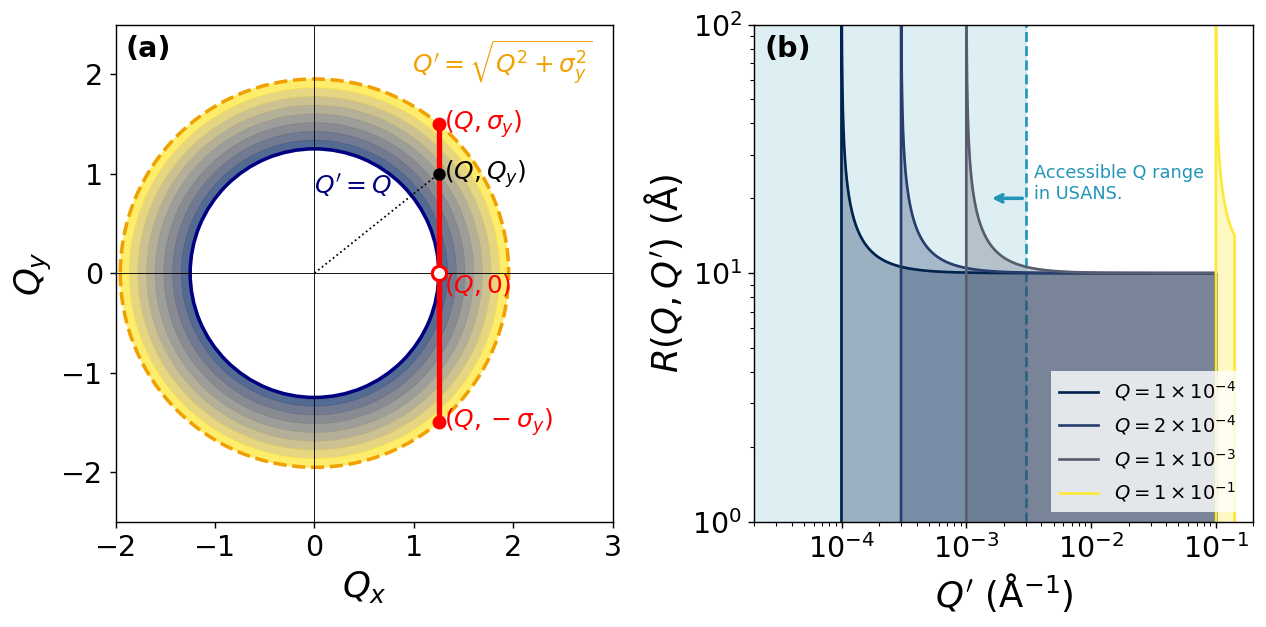

In [161]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

# Set parameters for the schematic
Qx_val = 1.25
sigma_y_val = 1.5
Qmax_val = np.sqrt(Qx_val**2 + sigma_y_val**2)

# Create the plot
fig, axs = plt.subplots(1, 2, figsize=(10, 5), dpi=128)
ax = axs[0]  # Use the first subplot for the schematic
# ax.set_facecolor('k')

# Draw axes
ax.axhline(0, color='black', lw=0.5)
ax.axvline(0, color='black', lw=0.5)

# Draw the integration slit
ax.plot([Qx_val, Qx_val], [-sigma_y_val, sigma_y_val], 'r-', lw=3, label='Slit Integration Path')

# Plot points
ax.plot([Qx_val], [0], 'ro', linestyle='None', marker='o', markersize=8,
        markerfacecolor='white', markeredgecolor='r',
        markeredgewidth=1.8, zorder=5)
ax.plot([Qx_val], [sigma_y_val], 'ro', linestyle='None', marker='o', markersize=6,
        markerfacecolor='r', markeredgecolor='r',
        markeredgewidth=1.8, zorder=5)
ax.plot([Qx_val], [-sigma_y_val], 'ro', linestyle='None', marker='o', markersize=6,
        markerfacecolor='r', markeredgecolor='r',
        markeredgewidth=1.8, zorder=5)

# Add labels for points
ax.text(Qx_val + 0.05, -0.12, '$(Q, 0)$', ha='left', va='center', fontsize=14, color='r')
ax.text(Qx_val + 0.05, sigma_y_val, '$(Q, \sigma_y)$', ha='left', va='center', fontsize=14, color='r')
ax.text(Qx_val + 0.05, -sigma_y_val, '$(Q, -\sigma_y)$', ha='left', va='center', fontsize=14, color='r')

# Draw arcs to represent Q'
# Arc for Q' = Q_x
arc_min = patches.Arc((0, 0), 2 * Qx_val, 2 * Qx_val, theta1=-180, theta2=180, color='navy', ls='-', label="$Q' = Q_x$ (min radius)", linewidth=2)
ax.add_patch(arc_min)
ax.text(0, 0.8, "$Q' = Q$", color='navy', fontsize=14)

# Arc for Q' = sqrt(Q_x^2 + sigma_y^2)
arc_max = patches.Arc((0, 0), 2 * Qmax_val, 2 * Qmax_val, theta1=-180, theta2=180, color='#F0A000', ls='--', label="$Q' = \sqrt{Q_x^2 + \sigma_y^2}$ (max radius)", linewidth=2)
ax.add_patch(arc_max)
ax.text(Qmax_val/2, 2, "$Q' = \sqrt{Q^2 + \sigma_y^2}$", color="#F0A000", fontsize=14)

# Draw a point (Q_x, Q_y) on the slit and the corresponding arc
Qy_sample = 1.0
Q_sample = np.sqrt(Qx_val**2 + Qy_sample**2)
ax.plot([Qx_val], [Qy_sample], 'ko')
ax.text(Qx_val + 0.05, Qy_sample, '$(Q, Q_y)$', ha='left', va='center', fontsize=14)
# arc_sample = patches.Arc((0, 0), 2 * Q_sample, 2 * Q_sample, theta1=0, theta2=np.degrees(np.arctan(Qy_sample/Qx_val)), color='black', ls=':', lw=1, label="$Q' = \sqrt{Q_x^2 + Q_y^2}$")
# ax.add_patch(arc_sample)
ax.plot([0, Qx_val], [0, Qy_sample], 'k:', lw=1)

# Draw shaded region representing the support of R(Q_x, Q') with radial gradient
angle_max = np.pi
theta_band = np.linspace(-angle_max, angle_max, 400)

n_bands = 8
r_edges = np.linspace(Qx_val, Qmax_val, n_bands + 1)
cmap = plt.cm.cividis

for i in range(n_bands):
    r0, r1 = r_edges[i]/1.002, r_edges[i + 1]*1.002  # slight expansion to avoid gaps

    x_outer_i = r1 * np.cos(theta_band)
    y_outer_i = r1 * np.sin(theta_band)
    x_inner_i = r0 * np.cos(theta_band[::-1])
    y_inner_i = r0 * np.sin(theta_band[::-1])

    ax.fill(
        np.r_[x_outer_i, x_inner_i],
        np.r_[y_outer_i, y_inner_i],
        color=cmap((i + 1) / n_bands),
        alpha=0.75,
        edgecolor="none",
        zorder=-3
    )

# Set labels and title
ax.set_xlabel('$Q_x$', fontsize=20)
ax.set_ylabel('$Q_y$', fontsize=20)

# Set limits and aspect ratio
ax.set_xlim(-2.0, 3.0)
ax.set_ylim(-2.5, 2.5)
ax.set_aspect('equal', adjustable='box')
ax.tick_params(axis='both', which='major', labelsize=16)
# ax.legend()
# ax.grid(True)
ax.text(0.02, 0.98, "(a)", transform=ax.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='left', fontweight='bold')

# panel b psf ----------------------------
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
ax2 = axs[1]
# Define the Q-range for the low-Q instrument
Q_min = 5e-5
Q_max = 0.2

# Define the Q-range for USANS 
Q_min_usans = 5e-5
Q_max_usans = 2e-3

# Generate experimental Q values for USANS and fine latent Q values for simulation
Q_sampled = np.logspace(np.log10(Q_min_usans), np.log10(Q_max_usans), 64)
Q_model = np.logspace(np.log10(Q_min/2), np.log10(Q_max*2), 32768)
mask = (Q_model >= Q_min) & (Q_model <= Q_max)

# Define the Q values for which PSFs will be plotted
Q_values = [1e-4, 3e-4, 1e-3, 1e-1]
f_R = lambda Q1, Q2: R_rect(Q1, Q2, sigma_x=1e-7, sigma_y=0.1,
                            nx=64, quad='gauss')

# Normalize the Q values for the colormap
norm = Normalize(vmin=np.log10(Q_values[0]), vmax=np.log10(Q_values[-1]))
cmap = plt.cm.cividis

# Plot the PSFs with gradiented color
for Q in Q_values:
    psf = f_R([Q], Q_model)
    color = cmap(norm(np.log10(Q)))
    power = int(np.floor(np.log10(Q)))
    digit = f"{np.exp(np.log10(Q)-power):.0f}"
    ax2.plot(Q_model, psf[0], label=fr'$Q={digit} \times 10^{{{power}}}$', color=color)
    ax2.fill_between(Q_model, psf[0], alpha=0.3, color=color)

ax2.axvline(3e-3, color="#2395B8",zorder=-20, linestyle='--')
ax2.fill_between([1e-5, 3e-3], [-1e3, -1e3], [1e3, 1e3], color="#2395B8",zorder=-20, alpha=0.15)
ax2.text(3.5e-3, 20, 'Accessible Q range \nin USANS.', color="#2395B8")
ax2.annotate(
    "",
    xy=(1.5e-3, 20),          # arrow head (left)
    xytext=(3e-3, 20),      # starts at x=3e-3
    arrowprops=dict(arrowstyle="->", color="#2395B8", lw=2),
    zorder=10
)

ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel(r"$Q'~(\mathrm{\AA^{-1}})$", fontsize=20)
ax2.set_ylabel(r"$R(Q, Q')~(\mathrm{\AA})$", fontsize=20)
ax2.tick_params(axis='both', which='major', labelsize=16)
ax2.set_ylim(1e-0, 1e2)
ax2.set_xlim(2e-5, 2e-1)
ax2.legend(
    frameon=True,
    fancybox=False,
    edgecolor='none',
    fontsize=11,
    loc='lower right',
    bbox_to_anchor=(1, 0.0),
    bbox_transform=ax2.transAxes
)
ax2.text(0.02, 0.98, "(b)", transform=ax2.transAxes, fontsize=16, verticalalignment='top', horizontalalignment='left', fontweight='bold')

plt.tight_layout()
plt.show()